# Create WecOptTool Model for the Marson WEC concept

In [262]:
import autograd.numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute, Bounds
import pygmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

### Waves and Frequency array

In [263]:
wavefreq = 1/7.4371 # Hz
f1 = wavefreq
nfreq = 2

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
print(freq)

amplitude = 0.5/2 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

[0.13446101 0.26892203]


#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\capytaine\meshes\meshes.py:759: RuntimeWarning: invalid value encountered in arctanh
  z_lid_comp = -np.arctanh(np.pi*g*p/omega_max**2) / (np.pi * p)


0.0


INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_1351"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-5.  0.  0.], name="rect0").
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="rect0").rotation_center = (-5.0, 0, 0)
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1351 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.io.meshio:Stor

0.0


INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_1371"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-15.   0.   0.], name="rect1").
INFO:capytaine.bodies.bodies:Clipping rect1 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="rect1").rotation_center = (-15.0, 0, 0)
INFO:capytaine.bodies.bodies:Clipping rect1 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1371 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=CollectionOfMeshes(..., name=

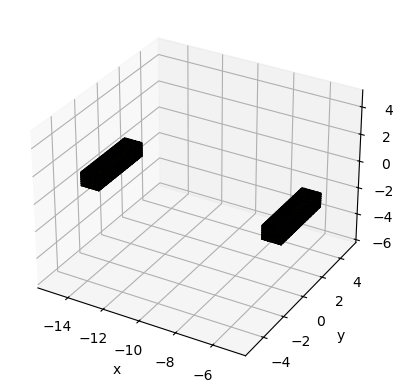

In [264]:
numBodies = 2
bodyDist = 10
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] #, 3]
mesh_size_factor = 0.16
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = []

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(f1*nfreq*2*np.pi)
        print(lid_pos)
        lid_pos = -.05
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()

        rect[nBod].center_of_mass = (bodyLocs[nBod], 0, 0)
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_translation_dof(name="Heave")
        rect[nBod].add_rotation_dof(name="Pitch")
        # rect[nBod].add_translation_dof(name="Surge")

        rect[nBod].inertia_matrix = rect[nBod].compute_rigid_body_inertia(rho=1025)
        rect[nBod].hydrostatic_stiffness = rect[nBod].immersed_part().compute_hydrostatic_stiffness(rho=1025)

        #print(rect[nBod].inertia_matrix)
        #print(rect[nBod].hydrostatic_stiffness)

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

#allBodies.show_matplotlib()
all_bodies.show_matplotlib()
ndof = all_bodies.nb_dofs

#all_bodies.show()

In [265]:
print(dir(all_bodies))
print(all_bodies.center_of_mass)
print(all_bodies.inertia_matrix)
print(all_bodies.hydrostatic_stiffness)
#all_bodies.show()

['__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rich_repr__', '__setattr__', '__short_str__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_infer_rotation_center', '_optional_params_str', '_repr_pretty_', 'add_all_rigid_body_dofs', 'add_dofs_labels_to_matrix', 'add_dofs_labels_to_vector', 'add_rotation_dof', 'add_translation_dof', 'animate', 'assemble_arbitrary_array', 'assemble_regular_array', 'center_of_buoyancy', 'center_of_mass', 'clip', 'clipped', 'cluster_bodies', 'combine_dofs', 'compute_hydrostatic_stiffness', 'compute_hydrostatics', 'compute_rigid_body_inertia', 'copy', 'disp_mass', 'dof_normals', 'dofs', 'each_hydrostatic_stiffness', 'extract_faces

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [266]:
min_computable_wavelength = all_bodies.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

In [267]:
bem_data = wot.run_bem(all_bodies, freq, wave_dirs=0)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file

INFO:capytaine.green_functions.delhommeau:Loading tabulation from C:\Users\jtgrasb\AppData\Local\capytaine\Cache\2.2\tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz
INFO:capytaine.bodies.bodies:Clipping rect0+rect1_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1351 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1371 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


[13:16:19] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=0.845, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect1__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0+rect1_immersed"), omega=1.690, water_depth=in

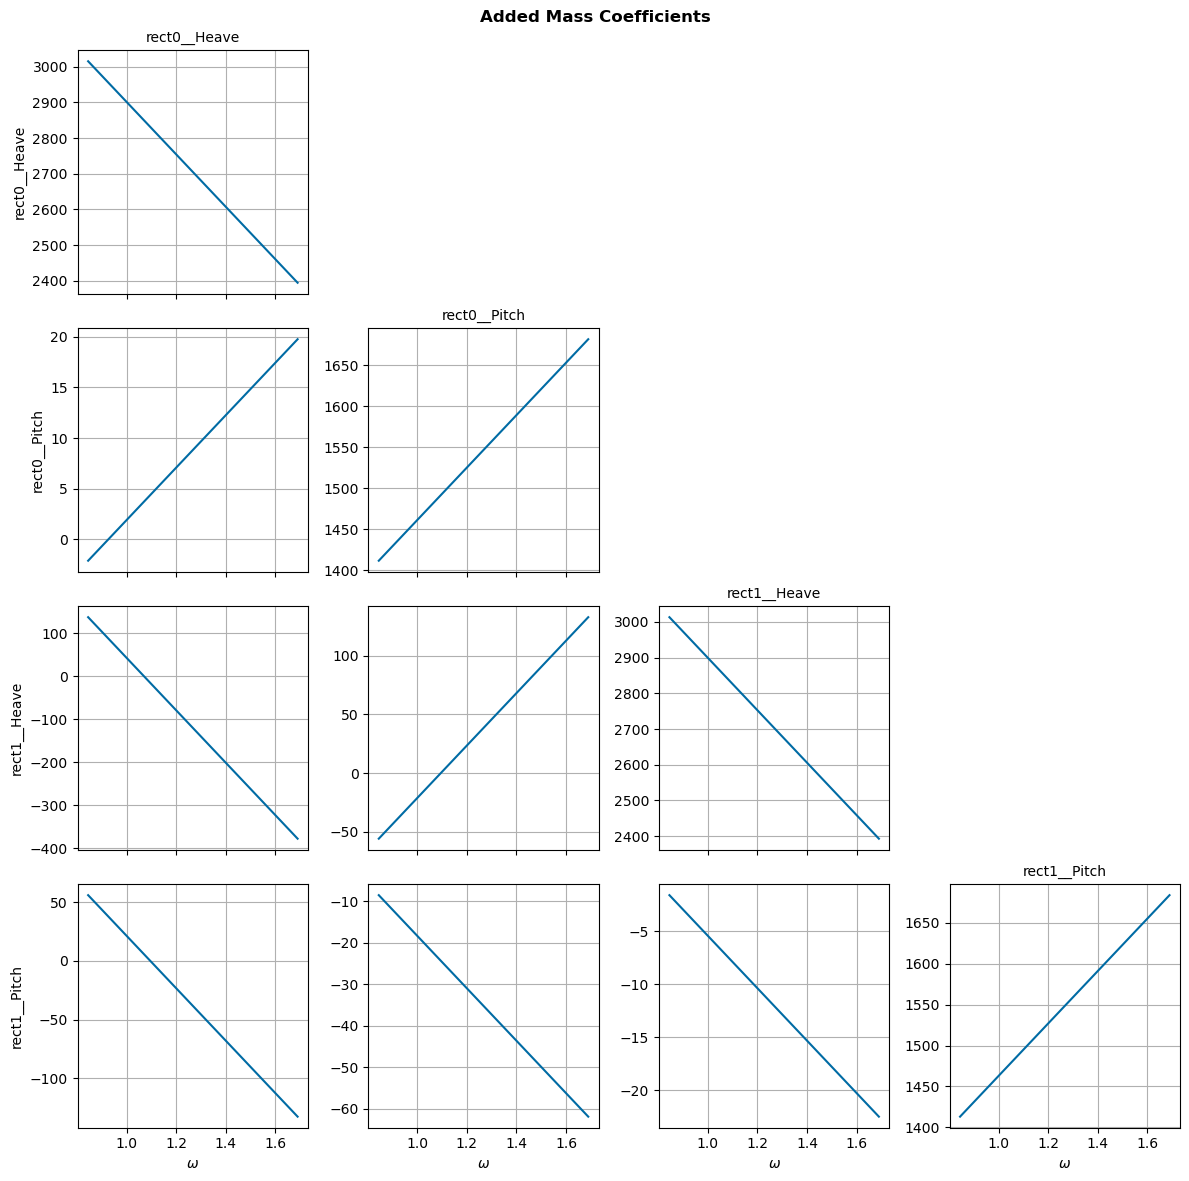

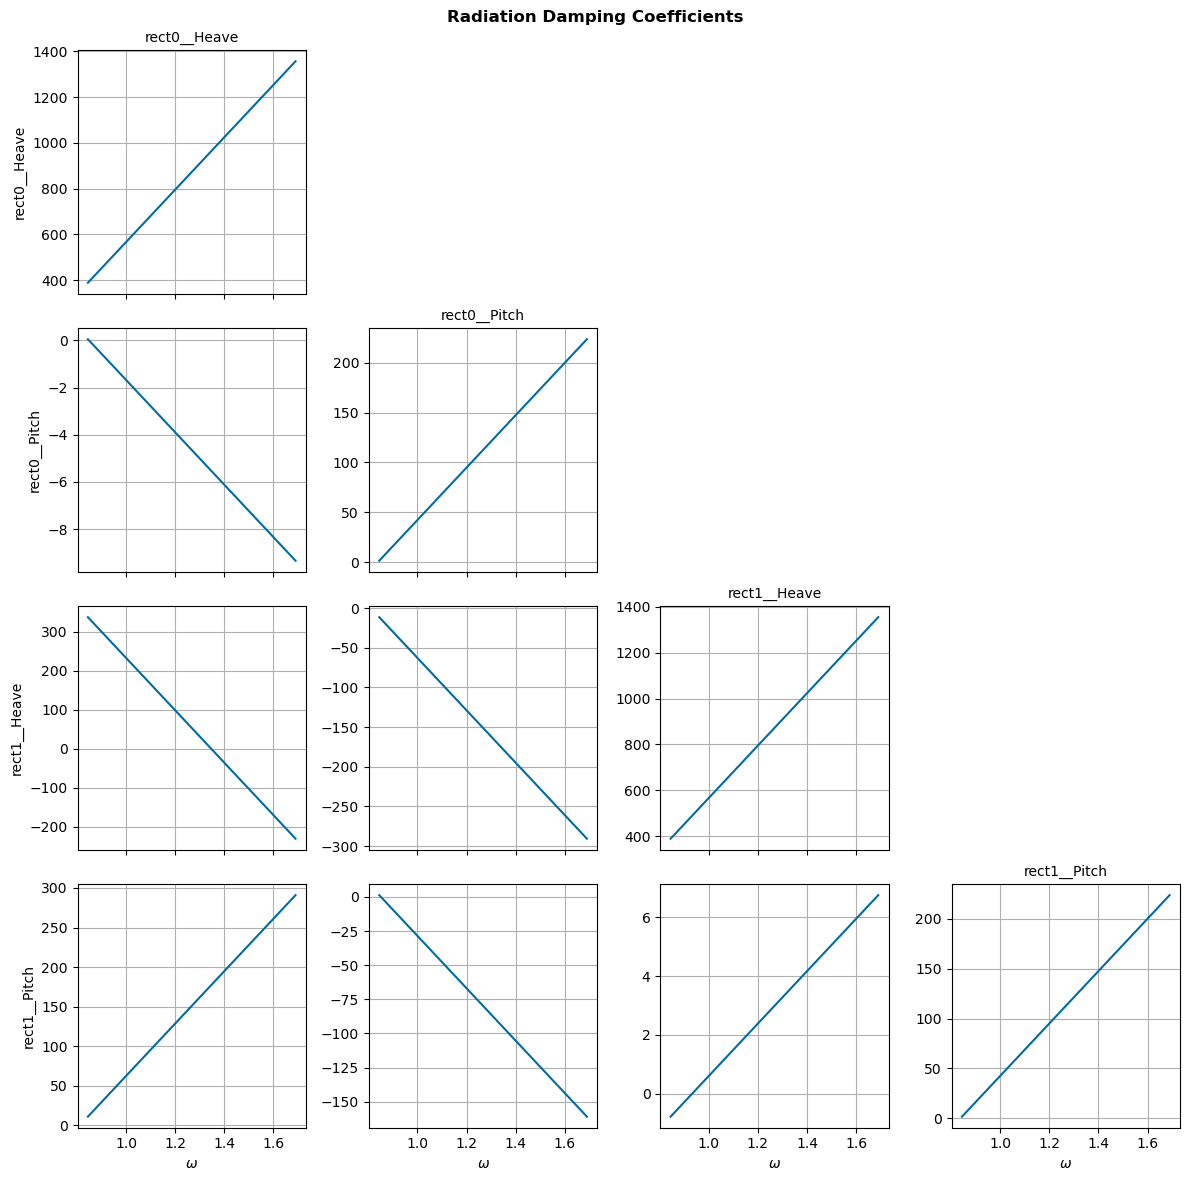

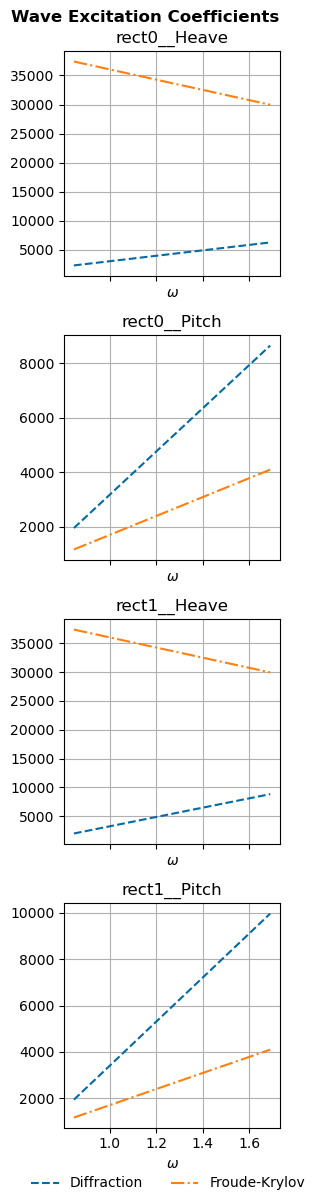

In [268]:
bem_data_sel = bem_data.sel(wave_direction = 0, method='nearest')
radiating_dofs = bem_data_sel.radiating_dof.values
influenced_dofs = bem_data_sel.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(
    len(radiating_dofs), 
    len(influenced_dofs),
    tight_layout=True, 
    sharex=True, 
    figsize=(3*len(radiating_dofs),3*len(influenced_dofs)),
    squeeze=False
    )
fig_rd, ax_rd = plt.subplots(
    len(radiating_dofs),
    len(influenced_dofs),
    tight_layout=True,
    sharex=True, 
    figsize=(3*len(radiating_dofs), 3*len(influenced_dofs)),
    squeeze=False
    )
fig_ex, ax_ex = plt.subplots(
    len(influenced_dofs),
    1,
    tight_layout=True, 
    sharex=True, 
    figsize=(3, 3*len(radiating_dofs)), 
    squeeze=False
    )
[ax.grid(True) for axs in (ax_am, ax_rd, ax_ex) for ax in axs.flatten()]
# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data_sel.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashed', label='Diffraction')
            np.abs(bem_data_sel.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashdot', label='Froude-Krylov')
            ex_handles, ex_labels = ax_ex[j,0].get_legend_handles_labels()
            ax_ex[j,0].set_title(f'{idof}')
            ax_ex[j,0].set_xlabel('')
            ax_ex[j,0].set_ylabel('')
        if j <= i:
            bem_data_sel.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data_sel.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j, 0].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)

In [269]:
#print(bem_data_sel.diffraction_force)

print(abs(bem_data['excitation_force']))

<xarray.DataArray 'excitation_force' (omega: 2, wave_direction: 1,
                                      influenced_dof: 4)> Size: 64B
array([[[35093.09911396,  3127.03385178, 35514.43709113,  3111.18013349]],

       [[24082.03490415, 12732.33462303, 21999.56110429, 14035.33621779]]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U20 80B 'rect0+rect1_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * wave_direction  (wave_direction) float64 8B 0.0
  * omega           (omega) float64 16B 0.8448 1.69
  * influenced_dof  (influenced_dof) object 32B 'rect0__Heave' ... 'rect1__Pi...
    period          (omega) float64 16B 7.437 3.719


In [270]:
nstate_pto = 2 # PTO forces
nstate_opt = nstate_pto
pto_ndof = 1

In [271]:
# PTO is simply based on the pitch of the float (assuming pitch is constrained about PTO location)
name1 = ["PTO_1"]
name2 = ["PTO_2"]
kinematics1 = np.array([[1,0]])
kinematics2 = np.array([[-1,1]]) # pto 2 should be relative pitch
inv_kinematics = np.array([[1,1]])

controller = wot.pto.controller_p
loss = None

## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 0.0
drivetrain_friction = 0.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance

pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

pto1 = wot.pto.PTO(pto_ndof, kinematics1, controller, pto_impedance, loss, name1[0])
pto2 = wot.pto.PTO(pto_ndof, kinematics2, controller, pto_impedance, loss, name2[0], inv_kinematics=inv_kinematics)

In [272]:
hydro_data = wot.add_linear_friction(bem_data, None)

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

print(hydro_data['hydrostatic_stiffness'])

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 4, radiating_dof: 4)> Size: 128B
array([[ 4.02210000e+04, -1.25590163e-12,  0.00000000e+00,
         0.00000000e+00],
       [-1.25590163e-12, -1.68005738e+04,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.02210000e+04,
         1.04658469e-12],
       [ 0.00000000e+00,  0.00000000e+00,  1.04658469e-12,
        -1.68022411e+04]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U20 80B 'rect0+rect1_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 32B 'rect0__Heave' ... 'rect1__Pitch'
  * influenced_dof  (influenced_dof) object 32B 'rect0__Heave' ... 'rect1__Pi...


In [273]:
hydro_data = wot.add_linear_friction(bem_data, None)

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

coeff_dict_heave = {}
coeff_dict_pitch = {}
coeff_dict = {}

#print(hydro_data)

# I think I need to create a new dataset instead of dictionary
coeff_data = xr.full_like(hydro_data,0)
coeff_data = coeff_data.drop_sel(influenced_dof=['rect0__Heave','rect1__Heave'], radiating_dof=['rect0__Heave','rect1__Heave'])

coeff_var_names = ['added_mass','radiation_damping','hydrostatic_stiffness','friction','inertia_matrix']
exc_coeff_var_names = ['Froude_Krylov_force','diffraction_force']

for coeff_name in coeff_var_names:
    #coeff_dict[coeff_var] = np.zeros((nfreq,2,2))
    #coeff_dict[coeff_var][:,[[0]],[[0]]] = hydro_data[coeff_name].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    #    hydro_data[coeff_name].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch']) # convert to pitch about PTO 1 location
    #coeff_dict[coeff_var][:,[[1]],[[0]]] = hydro_data[coeff_name].sel(influenced_dof=['rect1__Heave'],radiating_dof=['rect1__Heave'])*(3*bodyDist/2)**2 # does 3 coeff in square make sense?
    #coeff_dict[coeff_var][:,[[1]],[[1]]] = hydro_data[coeff_name].sel(influenced_dof='rect1__Heave',radiating_dof='rect1__Heave')*(bodyDist/2)**2 + \
    #    hydro_data[coeff_name].sel(influenced_dof=['rect1__Pitch'],radiating_dof=['rect1__Pitch']) # convert to pitch about PTO 1 location
    
    coeff_data[coeff_name].loc[dict(influenced_dof='rect0__Pitch',radiating_dof='rect0__Pitch')] = \
        hydro_data[coeff_name].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
        hydro_data[coeff_name].sel(influenced_dof='rect0__Pitch',radiating_dof='rect0__Pitch')
    coeff_data[coeff_name].loc[dict(influenced_dof='rect1__Pitch',radiating_dof='rect1__Pitch')] = \
        hydro_data[coeff_name].sel(influenced_dof='rect1__Heave',radiating_dof='rect1__Heave')*(bodyDist/2)**2 + \
        hydro_data[coeff_name].sel(influenced_dof='rect1__Pitch',radiating_dof='rect1__Pitch') # convert to pitch about PTO 1 location
    
    if coeff_name != 'inertia_matrix':
        coeff_data[coeff_name].loc[dict(influenced_dof='rect0__Pitch',radiating_dof='rect1__Pitch')] = \
            hydro_data[coeff_name].sel(influenced_dof='rect1__Heave',radiating_dof='rect1__Heave')*3*(bodyDist/2)**2 # does 3 coeff in square make sense? I don't think so
    
for exc_coeff_name in exc_coeff_var_names:
    coeff_data[exc_coeff_name].loc[dict(influenced_dof='rect0__Pitch')] = \
        hydro_data[exc_coeff_name].sel(influenced_dof='rect0__Heave')*bodyDist/2 \
            + hydro_data[exc_coeff_name].sel(influenced_dof='rect0__Pitch')
    coeff_data[exc_coeff_name].loc[dict(influenced_dof='rect1__Pitch')] = \
        hydro_data[exc_coeff_name].sel(influenced_dof='rect1__Heave')*bodyDist/2 \
            + hydro_data[exc_coeff_name].sel(influenced_dof='rect1__Pitch')

coeff_data['omega'] = hydro_data['omega']

rao_transfer_functions = dict()
rao_transfer_functions['radiation'] = (1j*coeff_data['omega']*coeff_data['radiation_damping'] + -1*coeff_data['omega']**2*coeff_data['added_mass'], False)
rao_transfer_functions['friction'] = (1j*coeff_data['omega']*coeff_data['friction'], False)

# include zero_freq in hydrostatics
hs = ((coeff_data['hydrostatic_stiffness'] + 0j).expand_dims({"omega": coeff_data['radiation_damping'].omega}, 0))
tmp = hs.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
hs = xr.concat([tmp, hs], dim='omega') #, data_vars='minimal')
rao_transfer_functions['hydrostatics'] = (hs, True)

print(rao_transfer_functions['hydrostatics'][0])
print(rao_transfer_functions['hydrostatics'][0].sel(influenced_dof='rect0__Pitch'))
print(rao_transfer_functions['hydrostatics'][0].transpose("omega", "radiating_dof", "influenced_dof").sel(influenced_dof='rect0__Pitch'))

linear_force_functions_about_PTO = dict()
for name, (value, zero_freq) in rao_transfer_functions.items():
    value = value.transpose("omega", "radiating_dof", "influenced_dof")
    value = -1*value  # RHS of equation: ma = Σf
    linear_force_functions_about_PTO[name] = (wot.force_from_rao_transfer_function(value, zero_freq))

# wave excitation
excitation_coefficients = {
    'Froude_Krylov': coeff_data['Froude_Krylov_force'],
    'diffraction': coeff_data['diffraction_force'],
}

for name, value in excitation_coefficients.items():
    linear_force_functions_about_PTO[name] = wot.force_from_waves(value)

#coeff_data['inertia_matrix'] = hydro_data['inertia_matrix'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
#    hydro_data['inertia_matrix'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])

rao_transfer_function = -1*coeff_data['omega']**2*coeff_data['inertia_matrix'] + 0j
inertia_fun = wot.force_from_rao_transfer_function(rao_transfer_function, False)
linear_force_functions_about_PTO['inertia'] = inertia_fun

#print(bem_data['inertia_matrix'])

#omega = np.expand_dims(wot.frequency(f1, nfreq, False)*2*np.pi, [1,2])
#inertia_matrix = np.expand_dims(hydro_data['inertia_matrix'], 0)
#rao_transfer_function = -1*omega**2*inertia_matrix + 0j

#linear_force_functions_about_PTO['inertia'] = (wot.force_from_rao_transfer_function(rao_transfer_function, False))

print(linear_force_functions_about_PTO) # heave 

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 2, radiating_dof: 2,
                                           omega: 3)> Size: 192B
array([[[ 988724.42617645+0.j,  988724.42617645+0.j,
          988724.42617645+0.j],
        [3016575.        +0.j, 3016575.        +0.j,
         3016575.        +0.j]],

       [[      0.        +0.j,       0.        +0.j,
               0.        +0.j],
        [ 988722.75894685+0.j,  988722.75894685+0.j,
          988722.75894685+0.j]]])
Coordinates:
  * omega           (omega) float64 24B 0.0 0.8448 1.69
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U20 80B 'rect0+rect1_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Pitch' 'rect1__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Pitch' 'rect1__Pitch'
<xarray.DataArray 'hydrostatic_stiffness' (radiating_dof: 2, omega: 3)> Size: 96B
array(

In [274]:
#print(bem_data['inertia_matrix'])
#print(abs(coeff_dict['diff']))
#print(coeff_dict['A'])
#print(coeff_dict['B'])
#print(coeff_data['inertia_matrix'])
#print(hydro_data['inertia_matrix'])
print(coeff_data['hydrostatic_stiffness'])
print(coeff_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Pitch'))

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 2, radiating_dof: 2)> Size: 32B
array([[ 988724.42617645, 3016575.        ],
       [      0.        ,  988722.75894685]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U20 80B 'rect0+rect1_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Pitch' 'rect1__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Pitch' 'rect1__Pitch'
<xarray.DataArray 'hydrostatic_stiffness' (radiating_dof: 2)> Size: 16B
array([ 988724.42617645, 3016575.        ])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U20 80B 'rect0+rect1_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Pitch' 'rect1__Pitch'
    influenced_dof  <U12 48B 'rect0__Pitch'


In [275]:

# PTO dynamics forcing function
f_add = {'PTO_1': pto1.force_on_wec, 'PTO_2': pto2.force_on_wec} | linear_force_functions_about_PTO

# Constraint
f_max = 2000
nsubsteps = 4
pto_max_pos = 30*np.pi/180

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto1.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

def const_heave(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    heave_theoretical = (bodyDist/2)*np.sin(x_wec[2*nfreq:])
    return (x_wec[:2*nfreq] - heave_theoretical).flatten()

def const_b2_pos(wec, x_wec, x_opt, waves): # surge of float 2 shouldn't have a mean of 0
    length_const = b2_pto_dist(wec, x_wec, x_opt, waves)
    return abs(0.5*bodyDist - length_const).flatten()

constraints = [
#    {'type': 'ineq', 'fun': const_f_pto},
#    {'type': 'eq', 'fun': const_heave},
#    {'type': 'ineq', 'fun': const_b2_pos},
]

In [276]:
# create wec manually

# add friction
hydro_data = wot.add_linear_friction(bem_data, None)
inertia_matrix = hydro_data['inertia_matrix'].values

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

# forces in the dynamics equations
linear_force_functions = wot.standard_forces(hydro_data)
f_add = f_add if (f_add is not None) else {}
forces = linear_force_functions | f_add
# constraints
constraints = constraints if (constraints is not None) else []
wec = wot.WEC(f1, nfreq, forces, constraints, inertia_in_forces=True, ndof=2) # only 2 pitch dof

#wec = wot.WEC.from_bem(
#    bem_data,
#    constraints=constraints,
#    friction=None,
#    f_add=f_add,
#)


In [277]:
def total_average_power(wec, x_wec, x_opt, waves):
    return pto1.average_power(wec, x_wec, x_opt, waves) + pto2.average_power(wec, x_wec, x_opt, waves)

obj_fun = total_average_power
#nstate_opt = 2*2*nfreq

bounds_pto = Bounds([-1e4, -1e4],[-1e4, -1e4])

options = {'maxiter': 20}
scale_x_wec = 1e2
scale_x_opt = 1e-1
scale_obj = 1e1

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    bounds_opt=bounds_pto,
    )

opt_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_average_power} W')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.03e+00, 1.00e+03, -3.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.03e+00, 1.00e+03, -3.60e+02]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -360.2575028659007
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimal average mechanical power: -36.02575028659007 W


[-8.88178420e-17  2.75388038e-02  3.40071755e-02 -1.42108547e-16
  7.10542736e-17 -8.02818399e-02 -5.14447845e-02  0.00000000e+00]
[-10000. -10000.]


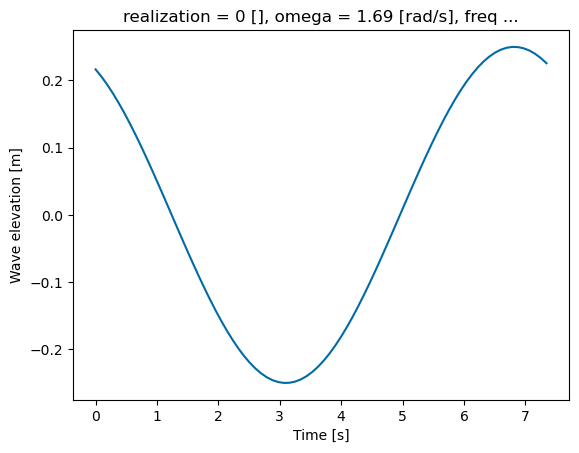

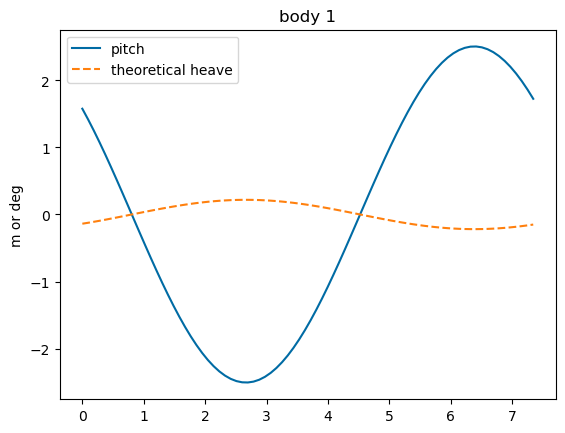

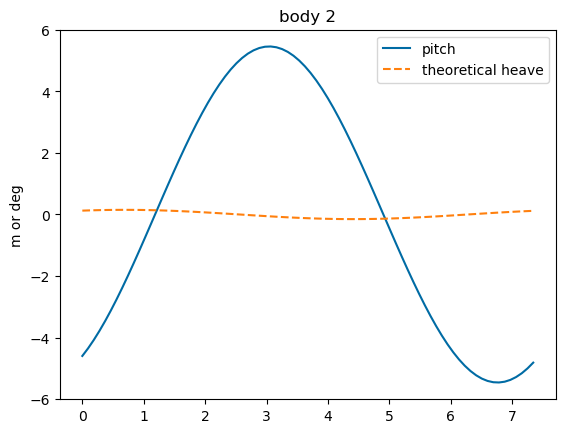

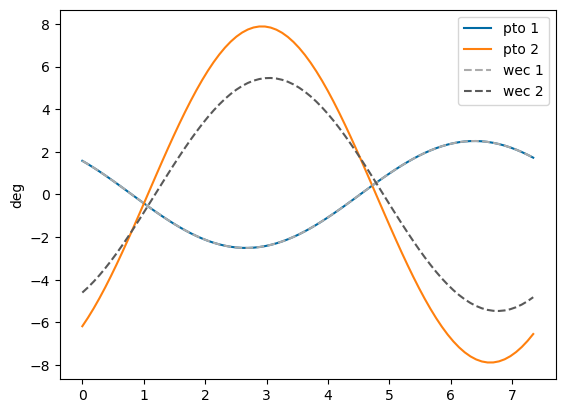

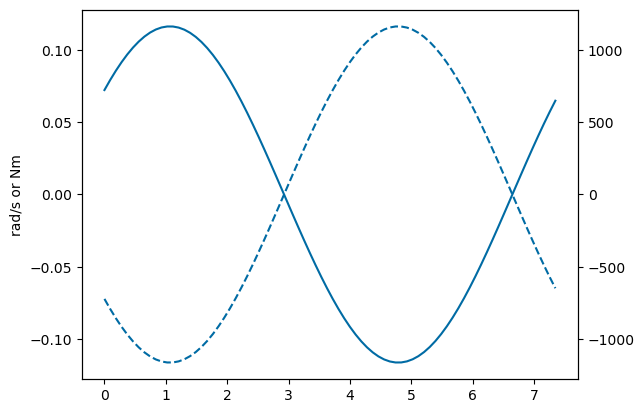

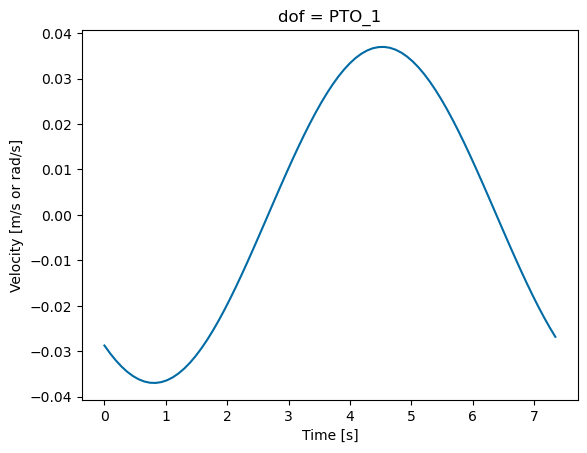

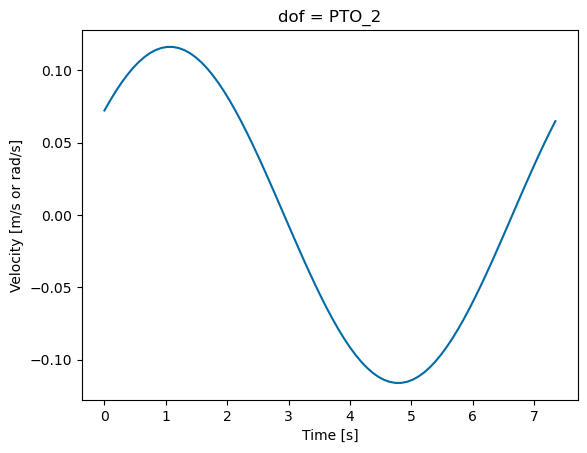

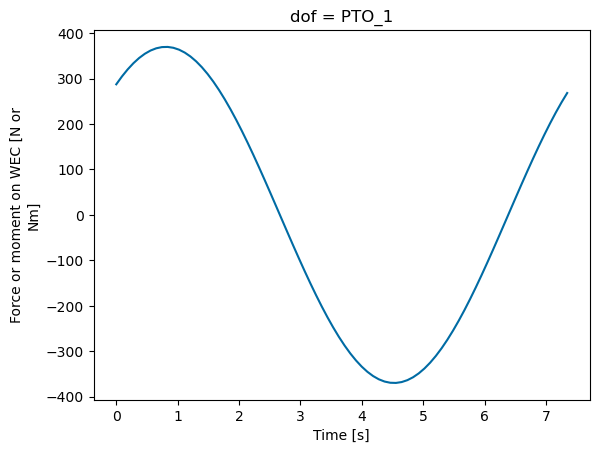

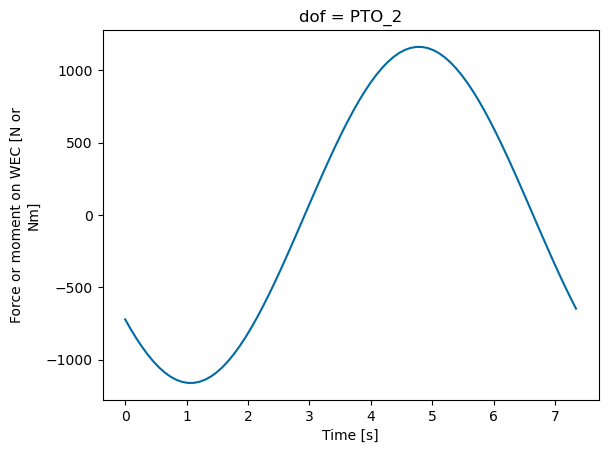

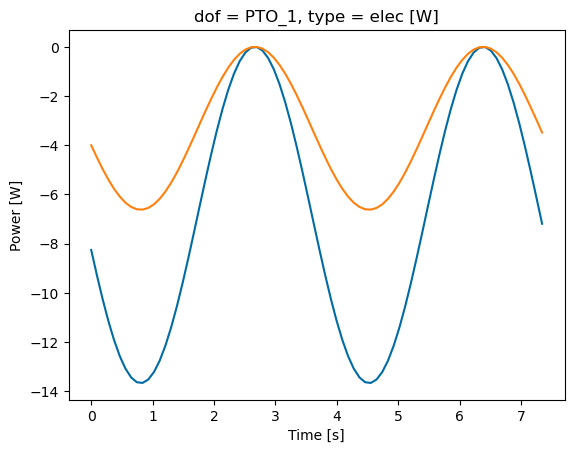

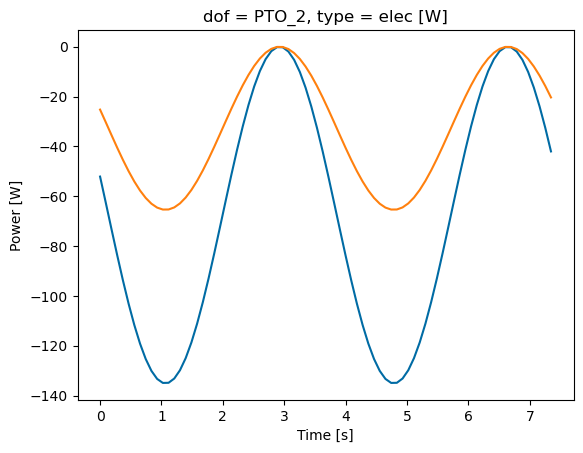

In [278]:
x_wec, x_opt = wec.decompose_state(results[0].x)
print(x_wec)
print(x_opt)

nsubsteps = 20
pto_fdom1, pto_tdom1 = pto1.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom2, pto_tdom2 = pto2.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

# because I converted the coefficients to be about the pto (which is relative motion for PTO 2), I need to convert them back to WEC frame
body1_pitch =  pto_tdom1[0]['pos']*(180/np.pi)
body2_pitch =  pto_tdom1[0]['pos'].squeeze()*(180/np.pi) + pto_tdom2[0]['pos'].squeeze()*(180/np.pi)

# calculate theoretical heave
theoretical_heave1 = -(bodyDist/2)*np.sin(pto_tdom1[0]['pos'])
theoretical_heave2 = -3*(bodyDist/2)*np.sin(pto_tdom1[0]['pos']).squeeze() - (bodyDist/2)*np.sin(pto_tdom2[0]['pos']).squeeze()

plt.figure()
wec_tdom[0]['wave_elev'].plot()


plt.figure()
plt.plot(wec_tdom[0]['time'], body1_pitch, label='pitch')
#wec_tdom[0]['pos'][1].plot(label='pitch')
plt.plot(wec_tdom[0]['time'], np.squeeze(theoretical_heave1),'--',label='theoretical heave')
plt.ylabel('m or deg')
plt.title('body 1')
plt.legend()

plt.figure()
plt.plot(wec_tdom[0]['time'], body2_pitch, label='pitch')
#wec_tdom[0]['pos'][1].plot(label='pitch')
plt.plot(wec_tdom[0]['time'], np.squeeze(theoretical_heave2),'--',label='theoretical heave')
plt.ylabel('m or deg')
plt.title('body 2')
plt.legend()

plt.figure()
plt.plot(pto_tdom1[0]['time'], pto_tdom1[0]['pos']*(180/np.pi), label='pto 1')
plt.plot(pto_tdom2[0]['time'], pto_tdom2[0]['pos']*(180/np.pi), label='pto 2')
plt.plot(wec_tdom[0]['time'], wec_tdom[0]['pos'][0]*(180/np.pi), '--',label='wec 1')
plt.plot(wec_tdom[0]['time'], wec_tdom[0]['pos'][1]*(180/np.pi), '--',label='wec 2')
plt.ylabel('deg')
plt.legend()

fig, ax1 = plt.subplots()
ax1.plot(pto_tdom2[0]['time'], pto_tdom2[0]['vel'], label='pto 2')
ax2 = ax1.twinx()
ax2.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='PTO_2')),'--')
ax1.set_ylabel('rad/s or Nm')


plt.figure()
pto_tdom1[0]['vel'].plot()

plt.figure()
pto_tdom2[0]['vel'].plot()

plt.figure()
pto_tdom1[0]['force'].plot()

plt.figure()
pto_tdom2[0]['force'].plot()

plt.figure()
pto_tdom1[0]['power'].loc['mech',:,:].plot()
pto_tdom1[0]['power'].loc['elec',:,:].plot()

plt.figure()
pto_tdom2[0]['power'].loc['mech',:,:].plot()
pto_tdom2[0]['power'].loc['elec',:,:].plot()


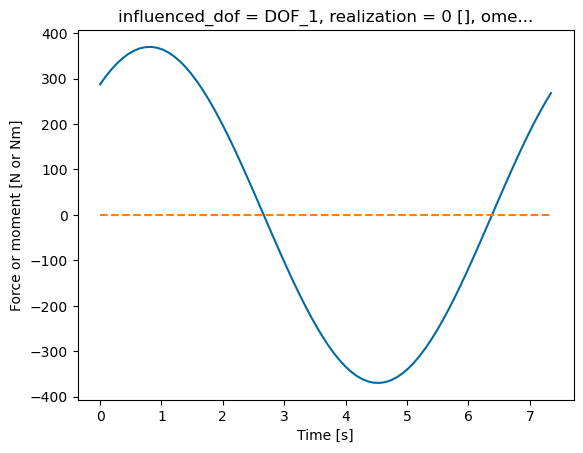

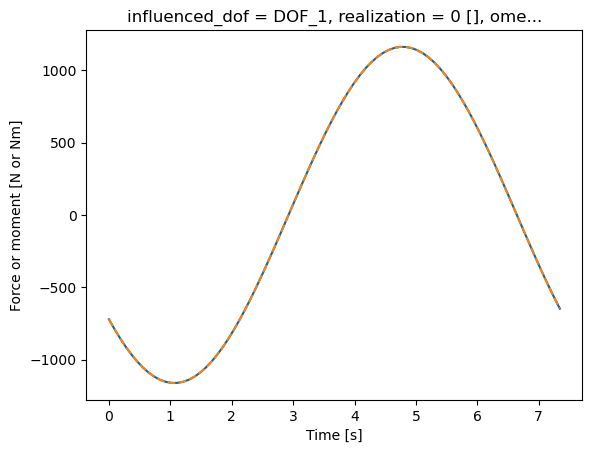

In [279]:
plt.figure()
wec_tdom[0]['force'].sel(type='PTO_1')[0].plot()
wec_tdom[0]['force'].sel(type='PTO_1')[1].plot(ls='--')

plt.figure()
wec_tdom[0]['force'].sel(type='PTO_2')[0].plot()
wec_tdom[0]['force'].sel(type='PTO_2')[1].plot(ls='--')

In [280]:
# check residual
resid_dof = 1

print(wec.forces)
if not wec.inertia_in_forces:
    ri = wec.inertia(wec, x_wec, x_opt, waves)[:,resid_dof]
else:
    ri = np.zeros([wec.ncomponents, wec.ndof])
# forces, -Σf
for f in wec.forces.values():
    ri = ri - f(wec, x_wec, x_opt, waves.sel(realization=0))#[:,resid_dof]
    
#print(wec.dofmat_to_vec(ri))

{'radiation': <function force_from_rao_transfer_function.<locals>.force at 0x000001B2853FFF60>, 'friction': <function force_from_rao_transfer_function.<locals>.force at 0x000001B2B78E0680>, 'hydrostatics': <function force_from_rao_transfer_function.<locals>.force at 0x000001B2B78E0AE0>, 'Froude_Krylov': <function force_from_waves.<locals>.force at 0x000001B2B70ADDA0>, 'diffraction': <function force_from_waves.<locals>.force at 0x000001B2B78E07C0>, 'PTO_1': <bound method PTO.force_on_wec of <wecopttool.pto.PTO object at 0x000001B287BC75D0>>, 'PTO_2': <bound method PTO.force_on_wec of <wecopttool.pto.PTO object at 0x000001B2B6C28290>>, 'inertia': <function force_from_rao_transfer_function.<locals>.force at 0x000001B2B78E2DE0>}


<xarray.DataArray 'type' (type: 8)> Size: 64B
array(['radiation', 'friction', 'hydrostatics', 'Froude_Krylov', 'diffraction',
       'PTO_1', 'PTO_2', 'inertia'], dtype=object)
Coordinates:
    realization  int32 4B 0
    omega        float64 8B 1.69
    freq         float64 8B 0.2689
    period       float64 8B 3.719
  * type         (type) object 64B 'radiation' 'friction' ... 'PTO_2' 'inertia'
Attributes:
    long_name:  Type


Text(0, 0.5, 'pitch hydrostatics b2')

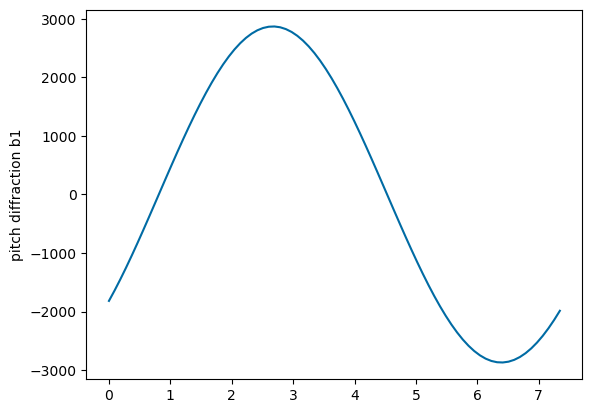

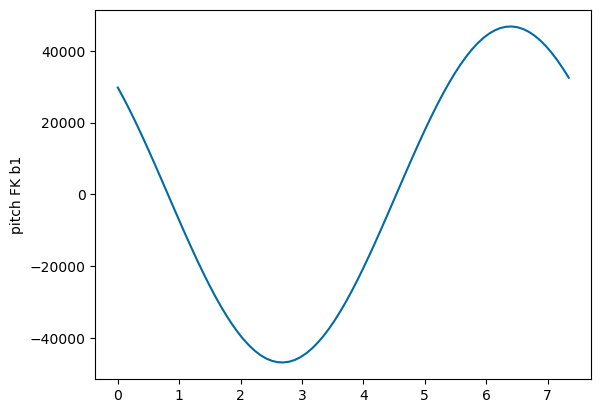

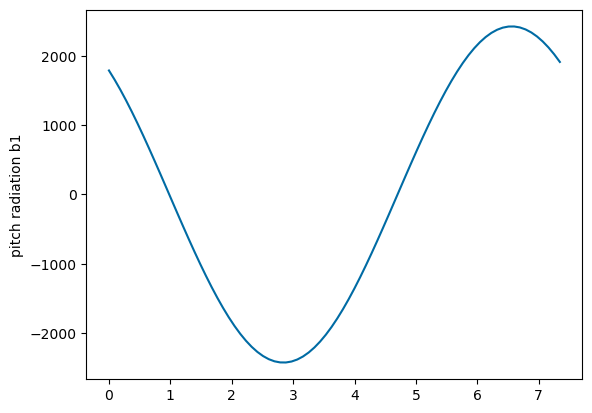

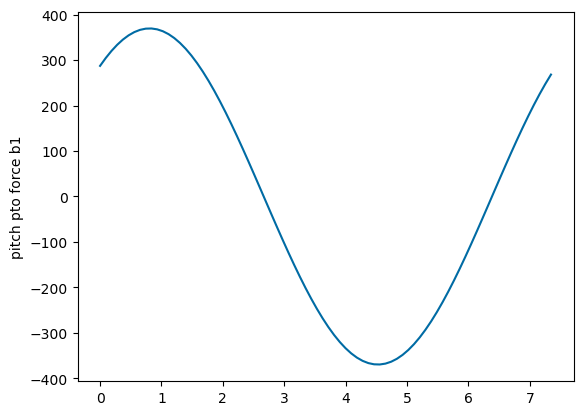

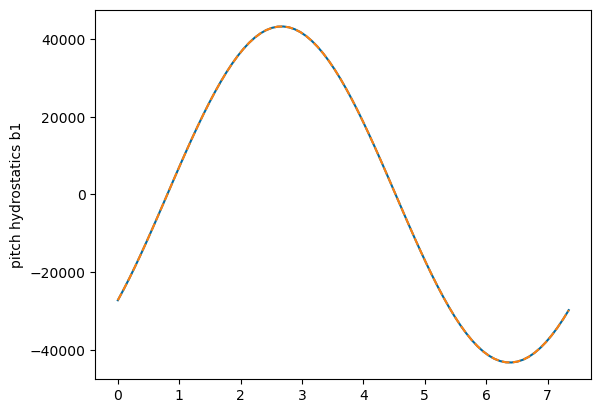

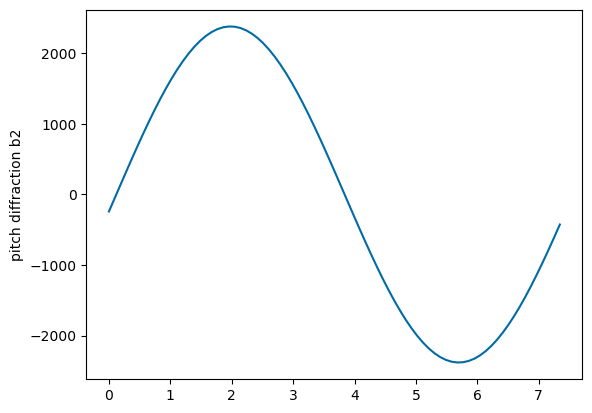

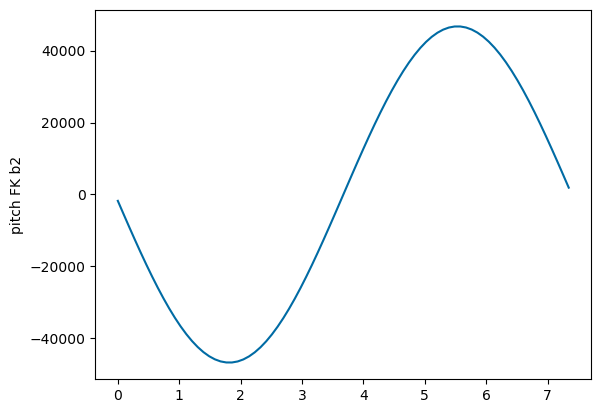

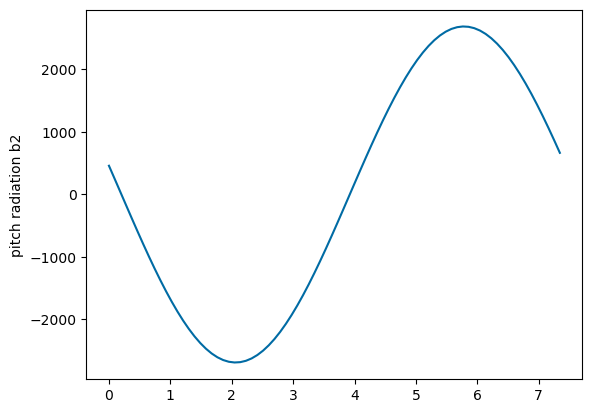

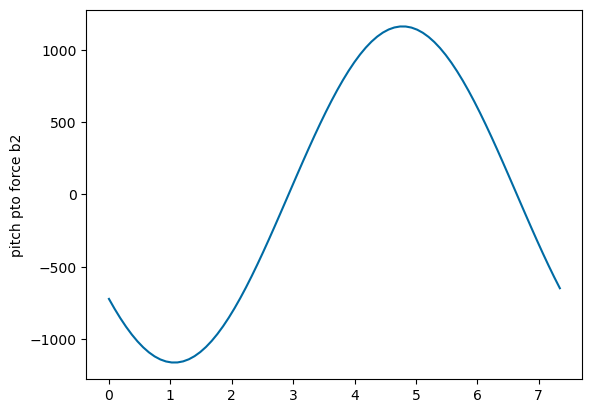

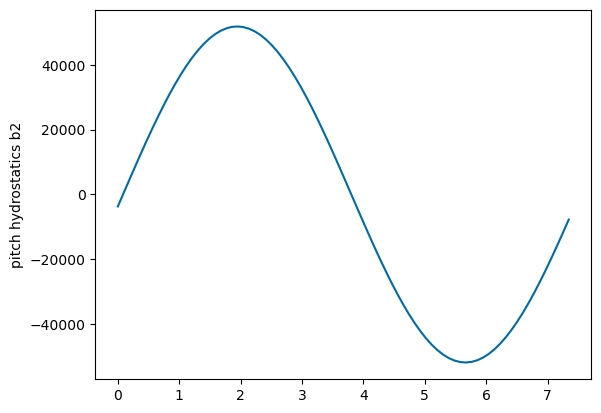

In [281]:
# check hydrostatics on body 1

hs_theoretical1 = -coeff_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Pitch',radiating_dof='rect0__Pitch')*wec_tdom[0]['pos'][0]

rad_theoretical1 = coeff_data['radiation_damping'].sel(influenced_dof='rect0__Pitch',radiating_dof='rect0__Pitch')*wec_tdom[0]['pos'][0]


print(wec_tdom[0]['force']['type'])

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][0].sel(type='diffraction')))
plt.ylabel('pitch diffraction b1')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][0].sel(type='Froude_Krylov')))
plt.ylabel('pitch FK b1')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][0].sel(type='radiation')))
plt.ylabel('pitch radiation b1')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][0].sel(type='PTO_1')))
plt.ylabel('pitch pto force b1')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][0].sel(type='hydrostatics')))
plt.plot(wec_tdom[0]['time'], hs_theoretical1,'--')
plt.ylabel('pitch hydrostatics b1')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='diffraction')))
plt.ylabel('pitch diffraction b2')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='Froude_Krylov')))
plt.ylabel('pitch FK b2')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='radiation')))
plt.ylabel('pitch radiation b2')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='PTO_2')))
plt.ylabel('pitch pto force b2')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='hydrostatics')))
plt.ylabel('pitch hydrostatics b2')